___
# Importing necessary libraries
___

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')


import plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

import cufflinks as cf
cf.go_offline()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Loading the dataset
df = pd.read_csv('../input/covid19-sentiments/COVID-19_Sentiments.csv')

In [3]:
df.head()

,Text_Id,Text,Date,Location,Sentiments
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,"Uttar Pradesh, India",0.000
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,Mumbai,0.000
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",Fri Mar 20 16:04:29 +0000 2020,"Jodhpur, India",0.350
3,1241032877099237379,RT @narendramodi: The young actors have someth...,Fri Mar 20 16:04:29 +0000 2020,"Gurugram, Bharat",0.125
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:28 +0000 2020,"New Delhi, India",0.000


In [ ]:
# Retaining only date in Date feature
df['Date'] = pd.to_datetime( df['Date'] ).dt.date

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
lis = []
for value in df.Sentiments:
    if value < 0 :
        lis.append(-1)
    elif value == 0 :
        lis.append(0)
    else:
        lis.append(1)
df['Sentiment Score'] = lis 
df.head()

In [ ]:
# Getting data of only first phase of lockdown
import datetime
phase_first = df[ (df.Date >= datetime.date(2020, 3, 25)) & (df.Date <= datetime.date(2020, 4, 14)) ]
phase_first.head()

In [ ]:
# Counting tweets only for +ve , -ve and neutral tweets
positive = list(phase_first['Sentiment Score']).count( 1 )
negative = list(phase_first['Sentiment Score']).count(-1 )
neutral  = list(phase_first['Sentiment Score']).count( 0 )

lis = [['positive' , positive] , ['negative' , negative] , ['neutral' , neutral]]
distribution = pd.DataFrame(lis , columns = ['Category' , 'Count'])
distribution

In [ ]:
px.pie( distribution , values='Count', names='Category', title='First phase Tweets Category distribution' ,color_discrete_sequence=px.colors.sequential.RdBu)

In [ ]:
df1 = df.drop(['Text', 'Sentiments', 'Location'], axis = 1)

In [ ]:
df1.head()

In [ ]:
df1['Date'] = pd.to_datetime( df1['Date'] )

In [ ]:
df1.info()

In [ ]:
df1['month']  = df1['Date'].dt.month
df1['day'] = df1['Date'].dt.day

In [ ]:
def different_models_performance(x , y):
    classifier = LogisticRegression()
    classifier.fit(x, y)
    print("Score for Logistic Regression : " , classifier.score(x,y))


    classifier = DecisionTreeClassifier()
    classifier.fit(x, y)
    print("Score for DecisionTreeClassifier : " , classifier.score(x,y))


    classifier = RandomForestClassifier()
    classifier.fit(x, y)
    print("Score for RandomForestClassifier : " , classifier.score(x,y))

In [ ]:
x = df1[['month', 'day']]
y = df1['Sentiment Score']
different_models_performance(x , y)

In [ ]:
df1['No. of words'] = df['Text']
df1['No. of words'] = df1['No. of words'].apply(lambda x : len(x.replace('\n' , ' ').split()))

In [ ]:
df1.head()

In [ ]:
x = df1[['month', 'day' , 'Text_Id' , 'No. of words']]
y = df1['Sentiment Score']
different_models_performance(x , y)

In [ ]:
df1.head()

In [ ]:
df1['Contains_HashTag'] = df['Text']
df1.head()

In [ ]:
df1['Contains_HashTag'] = df1['Contains_HashTag'].apply(lambda x : 0 if x.find('#') == -1 else 1 )
df1.head()

In [ ]:
x = df1[['month', 'day' , 'Text_Id' , 'No. of words' , 'Contains_HashTag']]
y = df1['Sentiment Score']
different_models_performance(x , y)

In [ ]:
#Finding the tweets of a particular handler
df['Text'][0].split(':')[0].split()[-1]

In [ ]:
df1['Account Handler'] = df['Text']
df1['Account Handler'] = df1['Account Handler'].apply(lambda x : x.split(':')[0].replace('RT' , '').replace(' ' , ''))
df1.head()

In [ ]:
# Finding the tweets of a particular tweet handler
account_handler_name = '@narendramodi'
df1[ df1['Account Handler'] == account_handler_name ] 

___
# State - Wise Sentiments Distribution
___

## Finding Popular hashtags

In [ ]:
def popular_hashtag_counter( df ):
    lis = []
    for val in df.Text:
        for v in val.split():
            if '#' in v[0]:
                lis.append(v)
    return pd.Series(lis).value_counts().head(5).to_frame().reset_index().rename( columns = {'index' : 'Popular HashTags' , 0 : 'Count'})

In [ ]:
popular_hashtags = popular_hashtag_counter( df )
popular_hashtags.iplot(kind = 'bar' , x = 'Popular HashTags' , y = 'Count' , title = 'Popular hashtags during first 4-phases of lockdown' , xTitle = 'HashTags' , yTitle = 'Count')  

In [ ]:
string = 'Andhra Pradesh    Hyderabad, Amaravati    Arunachal Pradesh    Itangar    Assam    Dispur    Bihar    Patna    Chhattisgarh    Raipur    Goa    Panaji    Gujarat    Gandhinagar    Haryana    Chandigarh    Himachal Pradesh    Shimla    Jammu and Kashmir    Srinagar and Jammu    Jharkhand    Ranchi    Karnataka    Bangalore    Kerala    Thiruvananthapuram    Madhya Pradesh    Bhopal    Maharashtra    Mumbai    Manipur    Imphal    Meghalaya    Shillong    Mizoram    Aizawi    Nagaland    Kohima    Orissa    Bhubaneshwar    Punjab    Chandigarh    Rajasthan    Jaipur    Sikkim    Gangtok    Tamil Nadu    Chennai    Telangana    Hyderabad    Tripura    Agartala    Uttaranchal    Dehradun    Uttar Pradesh    Lucknow    West Bengal    Kolkata'
states_lis = []
for i in range(0 , 57 , 2):
    states_lis.append([string.split('    ')[i] , string.split('    ')[i + 1] ])

# Printing values of states and capitals
for val in states_lis :
    print(val)

In [ ]:
def find_state_and_capital( state_name ):
    
    for val in states_lis:
        if (state_name.split()[0][1::] in val[0].split()[0]) and (len(state_name.split()) == len(val[0].split()) ) :
            return [val[0] , val[1]]
        
state_name = 'uttar pradesh'
state , capital = find_state_and_capital( state_name )
print(state , capital)

In [ ]:
def state_data( state_name ):
    
    state , capital = find_state_and_capital( state_name )
    lis = []
    for val in df['Location']:
        if (state in val) or (capital in val):
            lis.append(True)
        else:
            lis.append(False)
            
    neg = list(df[ lis ]['Sentiment Score']).count(-1 )
    neu = list(df[ lis ]['Sentiment Score']).count( 0 )
    pos = list(df[ lis ]['Sentiment Score']).count(+1 )
    
    print( 'Number of -1 tweets in ', state_name , '=>' , neg )
    print( 'Number of  0 tweets in ', state_name , '=>' , neu )
    print( 'Number of +1 tweets in ', state_name , '=>' , pos )
    
    liss = [ [ 'neg' , neg ] ,
            [ 'neu' , neu ] , 
            [ 'pos' , pos ] ]
    distribution = pd.DataFrame( liss , columns = ['Category' , 'Count'])
    pie_chart = px.pie( distribution , values='Count', names='Category', title='Category distribution for ' + '{' + state + '}' ,color_discrete_sequence=px.colors.sequential.RdBu)
    pie_chart.show()
    
    popular_hashtags = popular_hashtag_counter( df[lis] )
    bar_plot = popular_hashtags.iplot(kind = 'bar' , x = 'Popular HashTags' , y = 'Count' , title = 'Popular hashtags during lockdown for'  + '{' + state + '}', xTitle = 'HashTags' , yTitle = 'Count')  
    return pie_chart , bar_plot

In [ ]:
state_name = input("Enter the state/capital name whose data tweets distribution chart you want : ")
pie_chart , bar_plot = state_data( state_name )

# NLP Lgaye

In [4]:
df['Regenerated_Text'] = df['Text'].apply(lambda x: x.split(':')[-1])
df['Regenerated_Text'] = df['Regenerated_Text'].apply(lambda x: x.lower())
df['Regenerated_Text'] = df['Regenerated_Text'].apply(lambda x: x.replace('\n', ''))
df['Regenerated_Text'] = df['Regenerated_Text'].apply(lambda x: x.split('https')[0])

In [5]:
df.head()

,Text_Id,Text,Date,Location,Sentiments,Regenerated_Text
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,"Uttar Pradesh, India",0.000,shaheen bagh is still on.mosques are open.mui...
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,Mumbai,0.000,shaheen bagh is still on.mosques are open.mui...
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",Fri Mar 20 16:04:29 +0000 2020,"Jodhpur, India",0.350,"daughter of an ias, son of a kolkata officer,..."
3,1241032877099237379,RT @narendramodi: The young actors have someth...,Fri Mar 20 16:04:29 +0000 2020,"Gurugram, Bharat",0.125,the young actors have something to say..its t...
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:28 +0000 2020,"New Delhi, India",0.000,shaheen bagh is still on.mosques are open.mui...


In [7]:
for i in range(500):
    print(df['Regenerated_Text'][i])

 shaheen bagh is still on.mosques are open.muiiahs are saying corona won't harm if you read qalma.tiktokiye are m…
 shaheen bagh is still on.mosques are open.muiiahs are saying corona won't harm if you read qalma.tiktokiye are m…
 daughter of an ias, son of a kolkata officer, son of railway official, and a famous elite singer. all these are very in…
 the young actors have something to say..its time to be 'zyada savdhan' and do 'corona ka punchnama'! #indiafightscorona…
 shaheen bagh is still on.mosques are open.muiiahs are saying corona won't harm if you read qalma.tiktokiye are m…
 explosive batsmen who've seen teams through crises have something to say to us.we too will come together to fight covid…
 no more spreading rumors. this is the official website for corona updates.   updating every 4 hrs..  keep this link  for getti…
 that son of a top official in west bengal &amp; kanika kapoor both dodged mandatory corona screening. this is all you need to know…
 corona has proven that ind

In [11]:
# tokenization; process for creation of bag of words model.

corpus = []
for i in range(0, 648958):
    review = re.sub('[^a-zA-Z]', ' ', df['Regenerated_Text'][i])
    review = review.split()
    
    # The Porter stemming is used for removing the commoner
    # morphological and inflexional endings from words in English.
    ps = PorterStemmer()
    
    # Stopwords is a process of removing unnecessary english words
    # that are not took part in npl tasks.
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [12]:
len(corpus)


648958

In [24]:
# Creating new_sentiments column out of polarities in sentiments
New_Sentiments_ls = []

for senti in df['Sentiments']:
    if senti < 0:
        New_Sentiments_ls.append(-1)
    elif senti > 0:
        New_Sentiments_ls.append(1)
    else:
        New_Sentiments_ls.append(0)

New_Sentiments_ls = pd.DataFrame(New_Sentiments_ls, columns=['New_Sentiments'])

df = pd.concat([df, New_Sentiments_ls], axis=1)

In [25]:
df.head()

,Text_Id,Text,Date,Location,Sentiments,Regenerated_Text,New_Sentiments
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,"Uttar Pradesh, India",0.000,shaheen bagh is still on.mosques are open.mui...,0
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,Mumbai,0.000,shaheen bagh is still on.mosques are open.mui...,0
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",Fri Mar 20 16:04:29 +0000 2020,"Jodhpur, India",0.350,"daughter of an ias, son of a kolkata officer,...",1
3,1241032877099237379,RT @narendramodi: The young actors have someth...,Fri Mar 20 16:04:29 +0000 2020,"Gurugram, Bharat",0.125,the young actors have something to say..its t...,1
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:28 +0000 2020,"New Delhi, India",0.000,shaheen bagh is still on.mosques are open.mui...,0


In [26]:
cv = CountVectorizer()
cv = CountVectorizer(max_features=99500)
X = cv.fit_transform(corpus)
y = df.New_Sentiments.values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(f'X_train_shape-->{X_train.shape}; X_test_shape-->{X_test.shape}')

X_train_shape-->(454270, 99500); X_test_shape-->(194688, 99500)


In [45]:
def acc_call(y_test, y_pred):
    
    # Calculating accuracy
    acc_score = round(accuracy_score(y_test, y_pred)*100, 2)
    f_one_score = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
    acc_dict = {'Acc_Score': acc_score, 'F1_Score': f_one_score}
    
    return acc_dict

In [46]:
def checking_models(X_train, X_test, y_train, y_test):
    '''This function is used to check accuracy on different models of nlp'''
    
    # Fitting and predicting logistic regression to the Training set.
    logreg_classifier = LogisticRegression()
    logreg_classifier.fit(X_train, y_train)
    y_pred_logreg_test = logreg_classifier.predict(X_test)
    y_pred_logreg_train = logreg_classifier.predict(X_train)
    
    # Fitting and predicting Naive Bayes to the Training set.
    nv_classifier = MultinomialNB()
    nv_classifier.fit(X_train, y_train)
    y_pred_nv_test = nv_classifier.predict(X_test)
    y_pred_nv_train = nv_classifier.predict(X_train)

    # Fitting and predicting Decision Tree to Training set.
    tree_classifier = DecisionTreeClassifier()
    tree_classifier.fit(X_train, y_train)
    y_pred_tree_test = tree_classifier.predict(X_test)
    y_pred_tree_train = tree_classifier.predict(X_train)
    
    # Accuracy details.
    logreg_train_acc = acc_call(y_train, y_pred_logreg_train)
    logreg_test_acc = acc_call(y_test, y_pred_logreg_test)
    
    nv_train_acc = acc_call(y_train, y_pred_nv_train)
    nv_test_acc = acc_call(y_test, y_pred_nv_test)
    
    tree_train_acc = acc_call(y_train, y_pred_tree_train)
    tree_test_acc = acc_call(y_test, y_pred_tree_test)
    
    
    training_dict = {'Logistic Regression': logreg_train_acc,
                     'Naive Bayes': nv_train_acc,
                     'Decision Tree': tree_train_acc
                    }
    
    test_dict = {'Logistic Regression': logreg_test_acc,
                 'Naive Bayes': nv_test_acc,
                 'Decision Tree': tree_test_acc
                }
    
    print(f'Accuracy Checking for training data:- {training_dict}')
    print(f'Accuracy Checking for test data:- {test_dict}')
    
    # Returning dictionary of every prediction file for later use.
    pred_dict = {'Logistic_Regression_pred': [y_pred_logreg_train, y_pred_logreg_test],
                 'Naive_Bayes_pred': [y_pred_nv_train, y_pred_nv_test],
                 'Decision_Tree_pred': [y_pred_tree_train, y_pred_tree_test]
                }
    
    return pred_dict

In [47]:
all_dict = checking_models(X_train, X_test, y_train, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy Checking for training data:- {'Logistic Regression': {'Acc_Score': 87.43, 'F1_Score': 87.36}, 'Naive Bayes': {'Acc_Score': 81.8, 'F1_Score': 81.74}, 'Decision Tree': {'Acc_Score': 95.7, 'F1_Score': 95.7}}
Accuracy Checking for test data:- {'Logistic Regression': {'Acc_Score': 84.95, 'F1_Score': 84.83}, 'Naive Bayes': {'Acc_Score': 78.8, 'F1_Score': 78.67}, 'Decision Tree': {'Acc_Score': 95.99, 'F1_Score': 96.0}}


In [48]:
print(all_dict['Decision_Tree_pred'])

[array([ 0,  0,  1, ..., -1,  0,  0]), array([0, 0, 1, ..., 1, 1, 0])]


In [49]:
def con_mat_call(y_test, y_pred):
    
    # Creating confusion matrix
    unique_label = np.unique([y_test, y_pred])
    cmtx = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=unique_label), 
        index=['true:{:}'.format(x) for x in unique_label], 
        columns=['pred:{:}'.format(x) for x in unique_label]
    )
    
    return sns.heatmap(cmtx, cbar=False, annot=True, fmt='.2f')

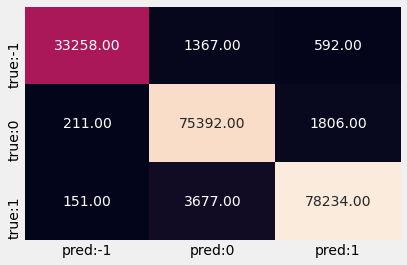

In [50]:
y_pred = all_dict['Decision_Tree_pred'][1]
con_mat_call(y_test, y_pred)